## Example python implementation for KNN purity score

In [84]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
import scvelo as scv

In [86]:
adata = scv.datasets.pancreas()

In [88]:
def knn_purity(adata, X_dim_red, cluster_col, k=100):
    '''
    Params:
    -------
    - adata: AnnData object
    - X_dim_red: string of slot opf adata.obsm to use for knn graph construction
    - cluster_col: string of name of column in adata.obs with cluster labels
    - k: number of nearest neighbors (default: k=100)
    '''
    ## Find k nearest neighbors    
    sc.pp.neighbors(adata, n_neighbors=k, key_added='knnpurity', use_rep=X_dim_red)

    ## Binarize the kNN matrix
    bin_knn_mat = adata.obsp['knnpurity_connectivities'].copy()
    bin_knn_mat[bin_knn_mat.nonzero()] = 1
    bin_knn_mat = bin_knn_mat.toarray()

    ## Calculate fraction of nearest neighbors with
    # same labels as the index cell
    cluster_labels = adata.obs[cluster_col].astype('str').values
    adata.obs['knn_purity_' + X_dim_red] = np.nan
    for i in range(bin_knn_mat.shape[0]):
        nn_labels = cluster_labels[bin_knn_mat[i,:].flatten()==1]
        knn_purity = sum(nn_labels == cluster_labels[i])/len(nn_labels)
        adata.obs.loc[adata.obs_names[i], 'knn_purity_' + X_dim_red] = knn_purity

In [89]:
knn_purity(adata, "X_pca", 'clusters_coarse')

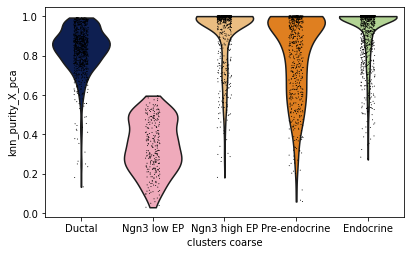

In [91]:
sc.pl.violin(adata, 'knn_purity_X_pca', groupby='clusters_coarse')

### Example conversion to R for plotting

You will need to install the `rpy2` package from terminal:
```
pip install rpy2
```

In [81]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

Run the chunk below separately to enable the use of R chunks

In [93]:
%load_ext rpy2.ipython

Now whenever you need you can run some R code, by starting the chunk with a line containing `%%R`, for example:

In [94]:
%%R
library(tidyverse)
library(patchwork)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



If you want to pass an object you have in python to be used in an R chunk you can add the `-i` option to the initial line. For example, if we have a pandas DataFrame like below

In [97]:
knn_purity_df = adata.obs[['knn_purity_X_pca', 'clusters_coarse']].copy()
knn_purity_df

,knn_purity_X_pca,clusters_coarse
index,,
AAACCTGAGAGGGATA,0.520000,Pre-endocrine
AAACCTGAGCCTTGAT,0.833935,Ductal
AAACCTGAGGCAATTA,0.854545,Endocrine
AAACCTGCATCATCCC,0.955357,Ductal
AAACCTGGTAAGTGGC,0.619048,Ngn3 high EP
...,...,...
TTTGTCAAGTGACATA,0.846154,Pre-endocrine
TTTGTCAAGTGTGGCA,0.991597,Ngn3 high EP
TTTGTCAGTTGTTTGG,0.903509,Ductal


We can pass it to R (**one word of caution:** the jupyter notebook interface doesn't know how to handle your R data well, e.g. if you just run `knn_purity_df` it will print _the whole_ dataframe and take ages to finish :D)

In [104]:
%%R -i knn_purity_df
head(knn_purity_df)

                 knn_purity_X_pca clusters_coarse
AAACCTGAGAGGGATA        0.5200000   Pre-endocrine
AAACCTGAGCCTTGAT        0.8339350          Ductal
AAACCTGAGGCAATTA        0.8545455       Endocrine
AAACCTGCATCATCCC        0.9553571          Ductal
AAACCTGGTAAGTGGC        0.6190476    Ngn3 high EP
AAACCTGGTATTAGCC        0.8875000          Ductal


and now we can use it in all the following R chunks

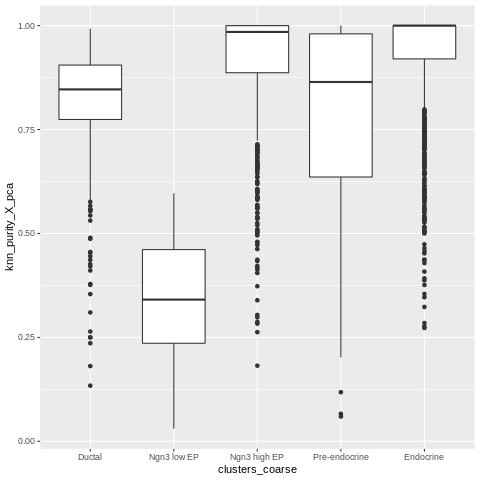

In [105]:
%%R 
knn_purity_df %>%
ggplot(aes(clusters_coarse, knn_purity_X_pca)) +
geom_boxplot()

If you want to modify a dataset in R and move it back to python you can use the `-o` option

In [106]:
%%R -o knn_purity_duct_df
knn_purity_duct_df <- knn_purity_df %>%
    filter(clusters_coarse=="Ductal")

In [107]:
knn_purity_duct_df

,knn_purity_X_pca,clusters_coarse
AAACCTGAGCCTTGAT,0.833935,Ductal
AAACCTGCATCATCCC,0.955357,Ductal
AAACCTGGTATTAGCC,0.887500,Ductal
AAACCTGTCTTTCCTC,0.875000,Ductal
AAACGGGAGACAATAC,0.934783,Ductal
...,...,...
TTTGCGCAGACAGACC,0.832117,Ductal
TTTGCGCGTCCAGTGC,0.725490,Ductal
TTTGGTTCAAAGCGGT,0.954198,Ductal
TTTGGTTCACCAGATT,0.792000,Ductal


You can adjust the display size for figures in the notebook using the `-w` and `-h` options

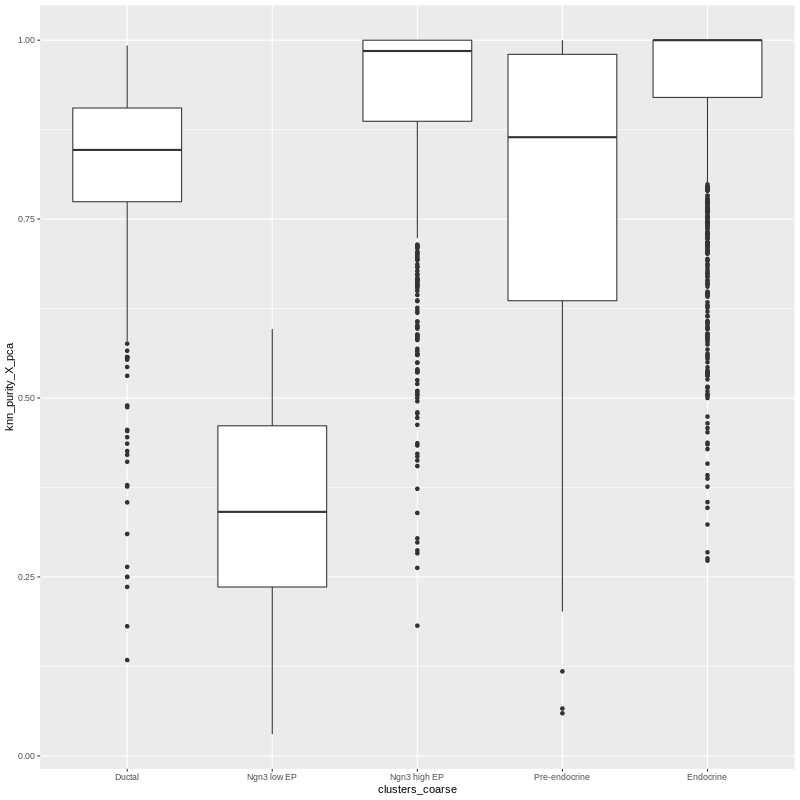

In [108]:
%%R -w 800 -h 800
knn_purity_df %>%
ggplot(aes(clusters_coarse, knn_purity_X_pca)) +
geom_boxplot()